In [1]:
import configparser
import datetime as dt
import sys
import collections
from pathlib import Path
from typing import Union, Optional, List, Tuple

import codebook.EDA as EDA
import codebook.clean as clean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('raph-base')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 30)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

np.random.seed(666)

In [3]:
sys.path.append(str(Path.cwd().parent))

from src.db_declaration import Base, Artist, CreditTrx, Genre, Label, Record
from src import db_functions
from src import utils

In [4]:
print(sys.executable)
print(sys.version)
print(f'sqlalchemy {sqlalchemy.__version__}')

C:\Users\r2d4\miniconda3\envs\py3\python.exe
3.8.3 (default, May 19 2020, 06:50:17) [MSC v.1916 64 bit (AMD64)]
sqlalchemy 1.3.17


## Connect To And (Re-)Create DB

In [8]:
CONFIG_PATH = Path.cwd().parent / "config.cfg"

In [12]:
path_to_db = utils.read_config_return_str(CONFIG_PATH, "SQLITE_DEV")
engine = utils.create_engine(path_to_db)
session = utils.create_session(engine)
utils.create_DB_anew(engine, Base)

C:\Users\r2d4\OneDrive\code\projects\20-02_disco\dev\DeafDiscoBase.db


### "Bulk" Load Data Into DB - NOT WORKING WITH TABLE RELATIONSHIPS

This is a fast approach using sqlalchemy core language, the problem is it copies the data from a df into a table, but does not take care of the relationships - the foreign keys are not created.

Btw: This is not the really fast bulk load with `conn.executemany()`, see [here](https://stackoverflow.com/a/32239587/13797028).

In [7]:
def load_albums_from_xlsx(
    filepath: Union[Path, str], genres: Optional[List] = None
) -> pd.DataFrame:
    """Load the original album collection file into a dataframe.
    You can specify a list of genres you want to include
    (defaults to None).
    """
    df = pd.read_excel(filepath, engine="openpyxl")
    if genres:
        df = df[df["Genre"].isin(genres)]
    return df

**TODO:** see the cleaning, this has to be formalized in a function

In [10]:
path_to_collection = utils.read_config_return_str(CONFIG_PATH, "COLLECTION")
collection_df = load_albums_from_xlsx(path_to_collection)
collection_df = clean.prettify_column_names(collection_df)
collection_df.dropna(thresh=8, inplace=True)
collection_df.rename(columns={"format": "record_format"}, inplace=True)
# collection_df["purchase_date"] = collection_df["purchase_date"].dt.date.astype(str)
# collection_df["number"] = collection_df["number"].astype(str)
# collection_df["digitized"] = collection_df["digitized"].map({True: 1, False: 0}).astype(int)
collection_df["label"].fillna("NA", inplace=True)  # because it creates a foreign key

# This is for the initial ingestion only
collection_df["credit_value"] = 0
collection_df["artist_country"] = None


In [11]:
collection_df.shape
collection_df.info()

(293, 16)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 292
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   active         293 non-null    float64       
 1   artist         293 non-null    object        
 2   title          293 non-null    object        
 3   record_format  293 non-null    object        
 4   year           293 non-null    float64       
 5   genre          293 non-null    object        
 6   price          293 non-null    float64       
 7   purchase_date  293 non-null    datetime64[ns]
 8   vinyl_color    197 non-null    object        
 9   lim_edition    207 non-null    object        
 10  number         24 non-null     object        
 11  label          293 non-null    object        
 12  digitized      293 non-null    object        
 13  remarks        72 non-null     object        
 14  rating         101 non-null    float64       
 15  credit_value   293 non-

In [12]:
EDA.display_nan(collection_df)

,total,prop,dtype
number,269,91.8%,object
remarks,221,75.4%,object
rating,192,65.5%,float64
vinyl_color,96,32.8%,object
lim_edition,86,29.4%,object


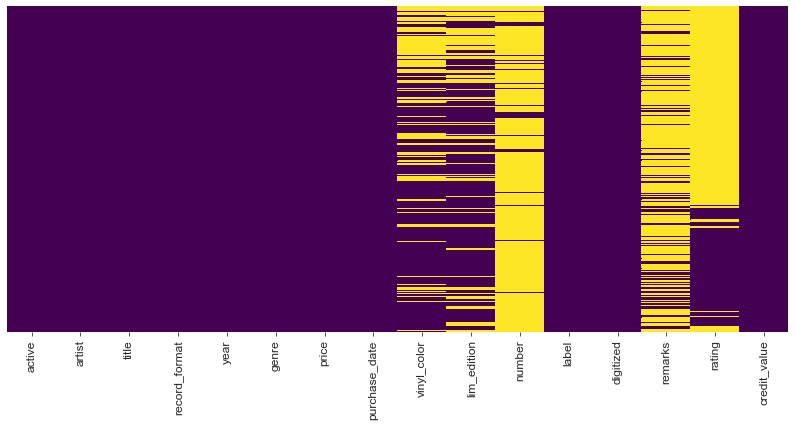

In [13]:
EDA.plot_nan(collection_df)

In [13]:
test_record = collection_df.to_dict("records")[-30]
test_record

{'active': 1.0,
 'artist': 'Living Gate',
 'title': 'Death Lust',
 'record_format': 'MLP',
 'year': 2020.0,
 'genre': 'Death Metal',
 'price': 20.0,
 'purchase_date': Timestamp('2020-07-01 00:00:00'),
 'vinyl_color': 'milky clear with blood red, black and white splatter',
 'lim_edition': 250,
 'number': nan,
 'label': 'Relapse Records',
 'digitized': True,
 'remarks': 'warped, etched on B-Side',
 'rating': 8.0,
 'credit_value': 0}

In [14]:
def insert_df_with_sqlalchemy_core(df, table_class, engine):
    start = time.time()
    engine.execute(
        table_class.__table__.insert(),
        [x for x in df.to_dict("records")]
    )
    end = time.time()
    print(
        f"SQLAlchemy Core: Insert {len(df)} records in {end - start:.2f} seconds"
    )

In [15]:
import time

insert_df_with_sqlalchemy_core(collection_df.iloc[:, :-1], Record, engine)

SQLAlchemy Core: Insert 293 records in 0.03 seconds


In [16]:
list(Record.__table__.columns)

[Column('record_id', Integer(), table=<records>, primary_key=True, nullable=False),
 Column('artist_id', Integer(), ForeignKey('artists.artist_id'), table=<records>),
 Column('title', String(), table=<records>, nullable=False),
 Column('genre_id', Integer(), ForeignKey('genres.genre_id'), table=<records>),
 Column('label', Integer(), ForeignKey('labels.label_id'), table=<records>),
 Column('year', Integer(), table=<records>),
 Column('format_id', Integer(), ForeignKey('formats.format_id'), table=<records>),
 Column('vinyl_color', String(), table=<records>),
 Column('lim_edition', String(), table=<records>),
 Column('number', String(), table=<records>),
 Column('remarks', String(), table=<records>),
 Column('purchase_date', Date(), table=<records>, nullable=False),
 Column('price', Numeric(), table=<records>, nullable=False),
 Column('digitized', Integer(), table=<records>, nullable=False),
 Column('rating', Integer(), table=<records>),
 Column('active', Integer(), table=<records>, null

In [17]:
# Reset DB
utils.create_DB_anew(engine, Base)

## Test "add_new_record"

**TODO**: Do I have to loop? Using apply only after all is done would be more efficient

In [18]:
test_record["artist"] = "Loving Gate"

In [19]:
db_functions.add_new_record(session, test_record)

C:\Users\r2d4\miniconda3\envs\py3\lib\site-packages\sqlalchemy\sql\sqltypes.py:660: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  util.warn(


In [20]:
from sqlalchemy import func
print(session.query(func.sum(CreditTrx.credit_value)).all()[0][0])

0.0


In [21]:
test_record

{'active': 1.0,
 'artist': 'Loving Gate',
 'title': 'Death Lust',
 'record_format': 'MLP',
 'year': 2020.0,
 'genre': 'Death Metal',
 'price': 20.0,
 'purchase_date': Timestamp('2020-07-01 00:00:00'),
 'vinyl_color': 'milky clear with blood red, black and white splatter',
 'lim_edition': 250,
 'number': nan,
 'label': 'Relapse Records',
 'digitized': True,
 'remarks': 'warped, etched on B-Side',
 'rating': 8.0,
 'credit_value': 0}

### Add all records

**TODO:** Can I apply()?

In [42]:
# Re-create DB
utils.create_DB_anew(engine, Base)

In [14]:
def insert_df_with_sqlalchemy_orm(session, df):
    for x in df.to_dict("records"):
        db_functions.add_new_record(session, x)

In [15]:
insert_df_with_sqlalchemy_orm(session, collection_df)

C:\Users\r2d4\miniconda3\envs\py3\lib\site-packages\sqlalchemy\sql\sqltypes.py:660: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  util.warn(


KeyError: 'artist_country'

In [45]:
session.query(Record).count()

293

## Query DB

In [26]:
for result in session.query(Record).filter(Record.title == "Death Lust").all():
    result

<Record(record_id=264, title=Death Lust, artist_id=167)>

In [27]:
session.query(Artist).count()
session.query(Artist).all()[:5]

188

[<Artist(artist_id=1, artist_name=Dismember)>,
 <Artist(artist_id=2, artist_name=Merciless)>,
 <Artist(artist_id=3, artist_name=Overkill)>,
 <Artist(artist_id=4, artist_name=Entombed)>,
 <Artist(artist_id=5, artist_name=Metallica)>]

In [28]:
session.query(Genre).count()
session.query(Genre).all()

9

[<Genre(genre_id=1, genre_name=Death Metal)>,
 <Genre(genre_id=2, genre_name=Thrash Metal)>,
 <Genre(genre_id=3, genre_name=Black Metal)>,
 <Genre(genre_id=4, genre_name=Speed Metal)>,
 <Genre(genre_id=5, genre_name=Hardcore)>,
 <Genre(genre_id=6, genre_name=Punk)>,
 <Genre(genre_id=7, genre_name=Crust)>,
 <Genre(genre_id=8, genre_name=Crossover)>,
 <Genre(genre_id=9, genre_name=Grindcore)>]

In [29]:
result = session.query(CreditTrx.credit_saldo).all()

np.array(result).min()
np.array(result).max()

0.0

0.0

In [30]:
from src.db_declaration import GenreLabelLink, ArtistLabelLink
from pprint import pprint

session.query(func.count(ArtistLabelLink.artist_id)).all()[0][0]
session.query(ArtistLabelLink).count()

for result in session.query(Artist).all()[:5]:
    pprint(result)

199

199

<Artist(artist_id=1, artist_name=Dismember)>
<Artist(artist_id=2, artist_name=Merciless)>
<Artist(artist_id=3, artist_name=Overkill)>
<Artist(artist_id=4, artist_name=Entombed)>
<Artist(artist_id=5, artist_name=Metallica)>


In [31]:
session.query(func.sum(CreditTrx.credit_value)).all()[0][0]

0.0

## Dev Credit Addition

In [32]:
for id_ in session.query(CreditTrx.credit_trx_id).all():
#     print(id_[0])
    to_delete = session.query(CreditTrx).filter(CreditTrx.credit_trx_id == id_[0]).one()
    session.delete(to_delete)

In [33]:
# Add fake Addition trx

fake_trx = CreditTrx(
    credit_trx_date=dt.datetime(year=2020, month=11, day=2),
    credit_trx_type="Addition",
    credit_value=1,
    credit_saldo=np.array(session.query(CreditTrx.credit_value).all()).sum() + 1,
    record_id=np.nan
)
session.add(fake_trx)

fake_trx = CreditTrx(
    credit_trx_date=dt.datetime(year=2020, month=11, day=1),
    credit_trx_type="Addition",
    credit_value=1,
    credit_saldo=np.array(session.query(CreditTrx.credit_value).all()).sum() + 1,
    record_id=np.nan
)
session.add(fake_trx)

fake_trx = CreditTrx(
    credit_trx_date=dt.datetime(year=2020, month=12, day=1),
    credit_trx_type="Test",
    credit_value=1,
    credit_saldo=np.array(session.query(CreditTrx.credit_value).all()).sum() + 1,
    record_id=np.nan
)
session.add(fake_trx)
# session.commit()

In [34]:
# Check
# session.commit()
session.query(CreditTrx).all()

[<CreditTrx(credit_trx_id=1, credit_trx_date=2020-11-02, credit_trx_type=Addition, credit_value=1.0, credit_saldo=1.0, record_id=None)>,
 <CreditTrx(credit_trx_id=2, credit_trx_date=2020-11-01, credit_trx_type=Addition, credit_value=1.0, credit_saldo=2.0, record_id=None)>,
 <CreditTrx(credit_trx_id=3, credit_trx_date=2020-12-01 00:00:00, credit_trx_type=Test, credit_value=1, credit_saldo=3.0, record_id=nan)>]

In [35]:
last_addition_date = (session
    .query(CreditTrx.credit_trx_date)
    .filter(CreditTrx.credit_trx_type == "Addition")
    .order_by(CreditTrx.credit_trx_date.desc())
    .first()
)[0]

days_since_last = (dt.date.today() - last_addition_date).days

In [36]:
last_addition_date
days_since_last

datetime.date(2020, 11, 2)

65

In [37]:
# while days_since_last >= 10:
#     fake_trx = CreditTrx(
#         credit_trx_date=last_addition_date + + dt.timedelta(days=10),
#         credit_trx_type="Addition",
#         credit_value=1,
#         credit_saldo=np.array(session.query(CreditTrx.credit_value).all()).sum() + 1,
#         record_id=np.nan
#     )
    
#     session.add(fake_trx)
    
#     last_addition_date = (session
#         .query(CreditTrx.credit_trx_date)
#         .filter(CreditTrx.credit_trx_type == "Addition")
#         .order_by(CreditTrx.credit_trx_date.desc())
#         .first()
#     )[0]
    
#     days_since_last = (dt.date.today() - last_addition_date).days

# session.commit()

In [38]:
def _get_days_since_last_addition() -> Tuple[dt.date, int]:
    """Return the date of and the number of days since the 
    last transaction with type 'Addition' stored in the 
    CreditTrx table. (This is called within 'add_credit').
    """
    last_addition_date = (session
        .query(CreditTrx.credit_trx_date)
        .filter(CreditTrx.credit_trx_type == "Addition")
        .order_by(CreditTrx.credit_trx_date.desc())
        .first()
    )[0]

    days_since_last = (dt.date.today() - last_addition_date).days
    
    return last_addition_date, days_since_last


def add_regular_credits(interval_days: int =10):
    """Every x days a new credit is added (to be spent
    on purchasing new records). This function checks
    the delta in days since the last addition and inserts
    the necessary credit transactions depending on the
    defined interval.
    """
    last_addition_date, days_since_last = _get_days_since_last_addition()
    
    while days_since_last >= 10:
        print(last_addition_date)
        addition_trx = CreditTrx(
            credit_trx_date=last_addition_date + dt.timedelta(days=interval_days),
            credit_trx_type="Addition",
            credit_value=1,
            credit_saldo=np.array(session.query(CreditTrx.credit_value).all()).sum() + 1,
            record_id=np.nan
        )
        session.add(addition_trx)
        last_addition_date, days_since_last = _get_days_since_last_addition()
    
    session.commit()

In [39]:
add_regular_credits()

2020-11-02
2020-11-12
2020-11-22
2020-12-02
2020-12-12
2020-12-22


In [40]:
session.query(CreditTrx).all()

[<CreditTrx(credit_trx_id=1, credit_trx_date=2020-11-02, credit_trx_type=Addition, credit_value=1.0, credit_saldo=1.0, record_id=None)>,
 <CreditTrx(credit_trx_id=2, credit_trx_date=2020-11-01, credit_trx_type=Addition, credit_value=1.0, credit_saldo=2.0, record_id=None)>,
 <CreditTrx(credit_trx_id=3, credit_trx_date=2020-12-01, credit_trx_type=Test, credit_value=1.0, credit_saldo=3.0, record_id=None)>,
 <CreditTrx(credit_trx_id=4, credit_trx_date=2020-11-12, credit_trx_type=Addition, credit_value=1.0, credit_saldo=4.0, record_id=None)>,
 <CreditTrx(credit_trx_id=5, credit_trx_date=2020-11-22, credit_trx_type=Addition, credit_value=1.0, credit_saldo=5.0, record_id=None)>,
 <CreditTrx(credit_trx_id=6, credit_trx_date=2020-12-02, credit_trx_type=Addition, credit_value=1.0, credit_saldo=6.0, record_id=None)>,
 <CreditTrx(credit_trx_id=7, credit_trx_date=2020-12-12, credit_trx_type=Addition, credit_value=1.0, credit_saldo=7.0, record_id=None)>,
 <CreditTrx(credit_trx_id=8, credit_trx_date=

In [41]:
# session.rollback()

In [16]:
session.close()